In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Bidirectional, TimeDistributed, RepeatVector, Activation, Dot, Lambda, GRU
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import gensim
import tensorflow_addons as tfa
import tensorflow as tf
import pandas as pd
import datetime
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# set all random seeds
np.random.seed(42)
tf.random.set_seed(42)

dataset_path = "./dev.csv"
df_dev = pd.read_csv(dataset_path, sep="\t", header=None,
                     names=["word", "tag", "lemm"])

dataset_path = "./test.csv"
df_test = pd.read_csv(dataset_path, sep="\t", header=None,
                      names=["word", "tag", "lemm"])

df_dev["word"] = df_dev["word"].astype(str)
df_dev["tag"] = df_dev["tag"].astype(str)
df_dev["lemm"] = df_dev["lemm"].astype(str)

df_test["word"] = df_test["word"].astype(str)
df_test["tag"] = df_test["tag"].astype(str)
df_test["lemm"] = df_test["lemm"].astype(str)

# remove head
df_dev = df_dev.iloc[1:]
df_test = df_test.iloc[1:]

# removing rows where tag is nan
df_dev = df_dev.dropna(subset=["tag"])
df_dev = df_dev[df_dev["tag"] != "nan"]
df_test = df_test.dropna(subset=["tag"])
df_test = df_test[df_test["tag"] != "nan"]

# lower case all words
df_test["word"] = df_test["word"].str.lower()
df_dev["word"] = df_dev["word"].str.lower()

def get_sentences(df):
    words = []
    tags = []
    lemmas = []
    sentence = []
    max_s = 0
    for index, row in df.iterrows():
        word = row["word"]
        tag = row["tag"]
        lemm = row["lemm"]
        sentence.append([word, tag, lemm])

        if row["word"] in [".", "?", "!", ";"]:
            words.append([word for word, tag, lemm in sentence])
            tags.append([tag for word, tag, lemm in sentence])
            lemmas.append([lemm for word, tag, lemm in sentence])
            max_s = max(max_s, len(sentence))
            sentence = []

    print("Max sentence length: ", max_s)
    return words, tags, lemmas

# _s is for string
dev_words_s, dev_tags_s, dev_lemmas_s = get_sentences(df_dev)
test_words_s, test_tags_s, test_lemmas_s = get_sentences(df_test)
print("Number of sentences in dev set: ", len(dev_words_s))
print("Number of sentences in test set: ", len(test_words_s))

for i in range(len(dev_words_s)):
    if len(dev_words_s[i]) != len(dev_tags_s[i]) or len(dev_words_s[i]) != len(dev_lemmas_s[i]):
        print("Dimension mismatch in sentence: ", i)
        print("Words: ", dev_words_s[i])
        print("Tags: ", dev_tags_s[i])
        print("Lemmas: ", dev_lemmas_s[i])
        break

Max sentence length:  95
Max sentence length:  107
Number of sentences in dev set:  703
Number of sentences in test set:  5596


Mean sentence length:  24.610241820768138


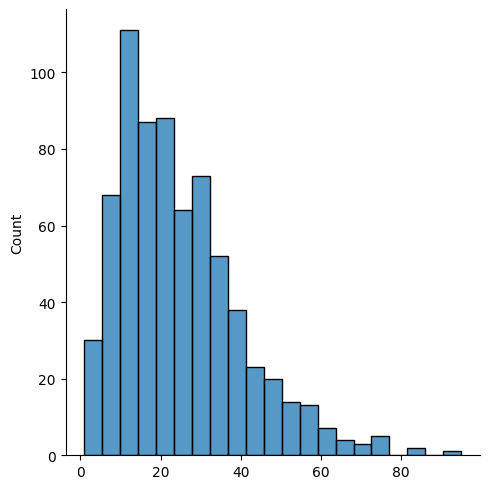

In [2]:
# max sentence length, mean, median 
mean_s = 0
for i in range(len(dev_words_s)):
    mean_s += len(dev_words_s[i])
mean_s /= len(dev_words_s)
print("Mean sentence length: ", mean_s)

# plot length distribution
lengths = [len(s) for s in dev_words_s]
sns.displot(lengths, kde=False)
plt.show()


In [3]:
# encode words
word_tokenizer = Tokenizer(filters="")
word_tokenizer.fit_on_texts(dev_words_s + test_words_s)
dev_words_e = word_tokenizer.texts_to_sequences(dev_words_s)
test_words_e = word_tokenizer.texts_to_sequences(test_words_s)

# encode tags
tag_tokenizer = Tokenizer(filters="")
tag_tokenizer.fit_on_texts(dev_tags_s + test_tags_s)
dev_tags_e = tag_tokenizer.texts_to_sequences(dev_tags_s)
test_tags_e = tag_tokenizer.texts_to_sequences(test_tags_s)

# encode lemmas
lemma_tokenizer = Tokenizer(filters="")
lemma_tokenizer.fit_on_texts(dev_lemmas_s + test_lemmas_s)
dev_lemmas_e = lemma_tokenizer.texts_to_sequences(dev_lemmas_s)
test_lemmas_e = lemma_tokenizer.texts_to_sequences(test_lemmas_s)

# look at first encoded data point
print("Word: ", dev_words_s[0])
print("Tag: ", dev_tags_s[0])
print("Lemma: ", dev_lemmas_s[0])
print("Encoded word: ", dev_words_e[0])
print("Encoded tag: ", dev_tags_e[0])
print("Encoded lemma: ", dev_lemmas_e[0])

print("\nNumber of unique words: ", len(word_tokenizer.word_index))
print("Number of unique tags: ", len(tag_tokenizer.word_index))
print("Number of unique lemmas: ", len(lemma_tokenizer.word_index))

Word:  ['mi', 'riferisco', 'al', 'lavoro', 'dove', 'non', "c'", '&egrave;', ',', 'innanzitutto', 'nel', 'mezzogiorno', ',', 'e', 'al', 'lavoro', 'che', 'cambia', '.']
Tag:  ['pron_per', 'v_gvrb', 'prep_a', 'nn', 'conj_s', 'adv', 'adv', 'v_essere', 'p_oth', 'adv', 'prep_a', 'nn_p', 'p_oth', 'conj_c', 'prep_a', 'nn', 'pron_rel', 'v_gvrb', 'p_eos']
Lemma:  ['mi', 'riferire', 'al', 'lavoro', 'dove', 'non', 'ci', 'essere', ',', 'innanzitutto', 'nel', 'mezzogiorno', ',', 'e', 'al', 'lavoro', 'che', 'cambiare', '.']
Encoded word:  [153, 8977, 31, 162, 99, 13, 75, 11, 1, 4242, 35, 1277, 1, 4, 31, 162, 5, 3359, 2]
Encoded tag:  [14, 5, 7, 1, 16, 8, 8, 13, 4, 8, 7, 9, 4, 11, 7, 1, 15, 5, 10]
Encoded lemma:  [167, 2613, 32, 147, 104, 14, 41, 4, 1, 3755, 39, 1380, 1, 5, 32, 147, 6, 642, 2]

Number of unique words:  19729
Number of unique tags:  31
Number of unique lemmas:  12857


In [4]:
MAX_SENTENCE_LENGTH = 50
PADDING_TYPE = "post"
TRUNCATING_TYPE = "post"

# pad encoded data
dev_words_e = tf.keras.preprocessing.sequence.pad_sequences(dev_words_e, maxlen=MAX_SENTENCE_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATING_TYPE)
test_words_e = tf.keras.preprocessing.sequence.pad_sequences(test_words_e, maxlen=MAX_SENTENCE_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATING_TYPE)
dev_tags_e = tf.keras.preprocessing.sequence.pad_sequences(dev_tags_e, maxlen=MAX_SENTENCE_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATING_TYPE)
test_tags_e = tf.keras.preprocessing.sequence.pad_sequences(test_tags_e, maxlen=MAX_SENTENCE_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATING_TYPE)
dev_lemmas_e = tf.keras.preprocessing.sequence.pad_sequences(dev_lemmas_e, maxlen=MAX_SENTENCE_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATING_TYPE)
test_lemmas_e = tf.keras.preprocessing.sequence.pad_sequences(test_lemmas_e, maxlen=MAX_SENTENCE_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATING_TYPE)

# print first encoded data point
print("Encoded words: ", dev_words_e[0])
print("Encoded tags: ", dev_tags_e[0])
print("Encoded lemmas: ", dev_lemmas_e[0])

Encoded words:  [ 153 8977   31  162   99   13   75   11    1 4242   35 1277    1    4
   31  162    5 3359    2    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Encoded tags:  [14  5  7  1 16  8  8 13  4  8  7  9  4 11  7  1 15  5 10  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Encoded lemmas:  [ 167 2613   32  147  104   14   41    4    1 3755   39 1380    1    5
   32  147    6  642    2    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [5]:
EMBEDDING_SIZE = 256
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# train word2vec model
word2vec = gensim.models.Word2Vec(dev_words_s + test_words_s, vector_size=EMBEDDING_SIZE, window=7, min_count=1, workers=4)

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec.wv[word]
    except KeyError:
        pass


In [8]:
print("Shape of dev words: ", dev_words_e.shape)
print("Shape of dev tags: ", dev_tags_e.shape)
print("Shape of dev lemmas: ", dev_lemmas_e.shape)
print("Shape of test words: ", test_words_e.shape)
print("Shape of test tags: ", test_tags_e.shape)
print("Shape of test lemmas: ", test_lemmas_e.shape)

Shape of dev words:  (703, 50)
Shape of dev tags:  (703, 50)
Shape of dev lemmas:  (703, 50)
Shape of test words:  (5596, 50)
Shape of test tags:  (5596, 50)
Shape of test lemmas:  (5596, 50)


In [19]:
# Bidirectional LSTM for lemmatization
# inputs:
#   - words: encoded words
#   - tags: encoded tags
# outputs:
#   - lemmas: encoded lemmas

def get_model():
    words = tf.keras.Input(shape=(MAX_SENTENCE_LENGTH,), name="words")
    tags = tf.keras.Input(shape=(MAX_SENTENCE_LENGTH,), name="tags")

    word_embedding = tf.keras.layers.Embedding(input_dim=VOCABULARY_SIZE, output_dim=EMBEDDING_SIZE, weights=[embedding_weights], trainable=True, name="word_embedding")(words)
    word_embedding = TimeDistributed(tf.keras.layers.Dense(EMBEDDING_SIZE, activation="swish"), name="time1")(word_embedding)
    tag_embedding = tf.keras.layers.Embedding(input_dim=len(tag_tokenizer.word_index) + 1, output_dim=EMBEDDING_SIZE, trainable = True, name="tag_embedding")(tags)
    tag_embedding = TimeDistributed(tf.keras.layers.Dense(EMBEDDING_SIZE, activation="swish"), name="time2")(tag_embedding)

    # concatenate word and tag embeddings
    Concatenate = tf.keras.layers.Concatenate()([word_embedding, tag_embedding])

    # bidirectional LSTM
    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True), name="lstm1")(Concatenate)
    lstm = tf.keras.layers.Dropout(0.5)(lstm)
    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True), name="lstm2")(lstm)

    dropout = tf.keras.layers.Dropout(0.5)(lstm)
    dense = tf.keras.layers.Dense(1024, activation="swish", name="dense1")(dropout)

    output = tf.keras.layers.Dense(len(lemma_tokenizer.word_index) + 1, activation="softmax", name="output")(dense)
    
    model = tf.keras.Model(inputs=[words, tags], outputs=output)
    
    return model


    
model = get_model()
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 words (InputLayer)             [(None, 50)]         0           []                               
                                                                                                  
 tags (InputLayer)              [(None, 50)]         0           []                               
                                                                                                  
 word_embedding (Embedding)     (None, 50, 256)      5050880     ['words[0][0]']                  
                                                                                                  
 tag_embedding (Embedding)      (None, 50, 256)      8192        ['tags[0][0]']                   
                                                                                            

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
history = model.fit(x={"words": dev_words_e, "tags": dev_tags_e}, y=dev_lemmas_e, batch_size=32, epochs=70, validation_split=0.1)

In [ ]:
result = model.evaluate(x={"words": test_words_e, "tags": test_tags_e}, y=test_lemmas_e)
print("Test loss: ", result[0])
print("Test accuracy: ", result[1])

175/175 [==============================] - 14s 81ms/step - loss: 5.3124 - sparse_categorical_accuracy: 0.7896
Test loss:  5.31242561340332
Test accuracy:  0.7896175980567932
